<a href="https://colab.research.google.com/github/Srijani-Das07/Plant-Disease-Detection-and-Classification-Baseline-Models/blob/main/ViT%2BCNN%2BGrad_CAM_Plant_Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [ ]:
# 1. Install required packages
!pip install -q kaggle tensorflow tensorflow-hub

# 2. Upload your Kaggle API key (only once per session)
from google.colab import files
files.upload()  # Upload kaggle.json

# 3. Configure Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 4. Download and extract dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!unzip -q plantvillage-dataset.zip -d plantvillage

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
 96% 1.96G/2.04G [00:16<00:01, 43.0MB/s]
100% 2.04G/2.04G [00:16<00:00, 131MB/s] 


In [ ]:
# 5. Imports
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import numpy as np
import os

In [ ]:
# 6. Prepare dataset
dataset_path = "plantvillage/plantvillage dataset/color"
class_names = sorted(os.listdir(dataset_path))
all_image_paths = []
all_labels = []

for class_index, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for fname in os.listdir(class_dir):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                all_image_paths.append(os.path.join(class_dir, fname))
                all_labels.append(class_index)

In [ ]:
# 7. Train/Val/Test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_paths, train_labels, test_size=0.2, stratify=train_labels, random_state=42)

In [ ]:
# 8. Preprocessing
IMG_SIZE = 224
BATCH_SIZE = 16

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def process_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0
    image = data_augmentation(image)
    return image, label

def prepare_dataset(paths, labels, shuffle=True):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    return ds.prefetch(tf.data.AUTOTUNE)

train_ds = prepare_dataset(train_paths, train_labels)
val_ds = prepare_dataset(val_paths, val_labels, shuffle=False)
test_ds = prepare_dataset(test_paths, test_labels, shuffle=False)

In [ ]:
# 9. Load ViT model
vit_url = "https://tfhub.dev/sayakpaul/vit_b16_fe/1"
vit_layer = hub.KerasLayer(vit_url, trainable=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

def create_cnn_branch(inputs):
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return x

# 10. Build hybrid model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
cnn_features = create_cnn_branch(inputs)
vit_features = layers.Lambda(lambda x: vit_layer(x), output_shape=(768,))(inputs)
combined = layers.Concatenate()([cnn_features, vit_features])

x = layers.Dense(512, activation='relu')(combined)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 768)       │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 896)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │    459,264 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 512)       │      2,048 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │    131,328 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 38)        │      9,766 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 696,678 (2.66 MB)

 Trainable params: 695,142 (2.65 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
# 11. Checkpointing

checkpoint_path = "/content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5"
epoch_file_path = "/content/drive/MyDrive/Plant Disease Detection/last_epoch_vitcnn_gradcam.txt"

class EpochCheckpoint(tf.keras.callbacks.Callback):
    def __init__(self, epoch_file_path):
        super().__init__()
        self.epoch_file_path = epoch_file_path

    def on_epoch_end(self, epoch, logs=None):
        with open(self.epoch_file_path, 'w') as f:
            f.write(str(epoch + 1))
        print(f"Epoch {epoch+1} completed. Val loss: {logs.get('val_loss')}, Val acc: {logs.get('val_accuracy')}")

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint_cb = ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
epoch_checkpoint = EpochCheckpoint(epoch_file_path)

In [ ]:
# 12. Resume if available
if os.path.exists(epoch_file_path):
    with open(epoch_file_path, 'r') as f:
        last_epoch_completed = int(f.read())
    print(f"Resuming training from epoch {last_epoch_completed}")
else:
    last_epoch_completed = 0
    print("Starting training from scratch")

if os.path.exists(checkpoint_path):
    model = load_model(checkpoint_path, custom_objects={'KerasLayer': hub.KerasLayer})
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
else:
    print("Checkpoint not found, using freshly defined model.")

# 13. Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    initial_epoch=last_epoch_completed,
    callbacks=[early_stop, checkpoint_cb, epoch_checkpoint],
    verbose=1
)

Starting training from scratch
Checkpoint not found, using freshly defined model.
Epoch 1/10
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.5100 - loss: 1.9941
Epoch 1: val_loss improved from inf to 0.17540, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 1 completed. Val loss: 0.1754021793603897, Val acc: 0.9470595121383667
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 898s 400ms/step - accuracy: 0.5101 - loss: 1.9937 - val_accuracy: 0.9471 - val_loss: 0.1754
Epoch 2/10
2172/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8770 - loss: 0.4053
Epoch 2: val_loss improved from 0.17540 to 0.08865, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 2 completed. Val loss: 0.08864829689264297, Val acc: 0.972263753414154
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 898s 410ms/step - accuracy: 0.8770 - loss: 0.4052 - val_accuracy: 0.9723 - val_loss: 0.0886
Epoch 3/10
2172/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9268 - loss: 0.2448
Epoch 3: val_loss improved from 0.08865 to 0.06921, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 3 completed. Val loss: 0.06921113282442093, Val acc: 0.9787086844444275
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 887s 393ms/step - accuracy: 0.9268 - loss: 0.2448 - val_accuracy: 0.9787 - val_loss: 0.0692
Epoch 4/10
2172/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9468 - loss: 0.1791
Epoch 4: val_loss improved from 0.06921 to 0.06081, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 4 completed. Val loss: 0.060810886323451996, Val acc: 0.9787086844444275
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 856s 390ms/step - accuracy: 0.9468 - loss: 0.1791 - val_accuracy: 0.9787 - val_loss: 0.0608
Epoch 5/10
2172/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9534 - loss: 0.1487
Epoch 5: val_loss improved from 0.06081 to 0.04558, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 5 completed. Val loss: 0.04557926207780838, Val acc: 0.9852687120437622
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 856s 390ms/step - accuracy: 0.9534 - loss: 0.1487 - val_accuracy: 0.9853 - val_loss: 0.0456
Epoch 6/10
2172/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9592 - loss: 0.1276
Epoch 6: val_loss improved from 0.04558 to 0.04218, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 6 completed. Val loss: 0.04217712953686714, Val acc: 0.9869950413703918
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 857s 391ms/step - accuracy: 0.9592 - loss: 0.1276 - val_accuracy: 0.9870 - val_loss: 0.0422
Epoch 7/10
2172/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9673 - loss: 0.1060
Epoch 7: val_loss improved from 0.04218 to 0.03840, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 7 completed. Val loss: 0.03839678317308426, Val acc: 0.9876855611801147
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 861s 390ms/step - accuracy: 0.9673 - loss: 0.1060 - val_accuracy: 0.9877 - val_loss: 0.0384
Epoch 8/10
2172/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9687 - loss: 0.0967
Epoch 8: val_loss improved from 0.03840 to 0.03634, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 8 completed. Val loss: 0.03633634373545647, Val acc: 0.9895269870758057
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 868s 393ms/step - accuracy: 0.9687 - loss: 0.0967 - val_accuracy: 0.9895 - val_loss: 0.0363
Epoch 9/10
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9723 - loss: 0.0858
Epoch 9: val_loss improved from 0.03634 to 0.03452, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 9 completed. Val loss: 0.034518513828516006, Val acc: 0.9894118905067444
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 871s 397ms/step - accuracy: 0.9723 - loss: 0.0858 - val_accuracy: 0.9894 - val_loss: 0.0345
Epoch 10/10
2172/2173 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9740 - loss: 0.0785
Epoch 10: val_loss improved from 0.03452 to 0.02919, saving model to /content/drive/MyDrive/Plant Disease Detection/model_checkpoint_vitcnn_gradcam.h5


Epoch 10 completed. Val loss: 0.029187649488449097, Val acc: 0.9910231232643127
2173/2173 ━━━━━━━━━━━━━━━━━━━━ 907s 413ms/step - accuracy: 0.9740 - loss: 0.0785 - val_accuracy: 0.9910 - val_loss: 0.0292


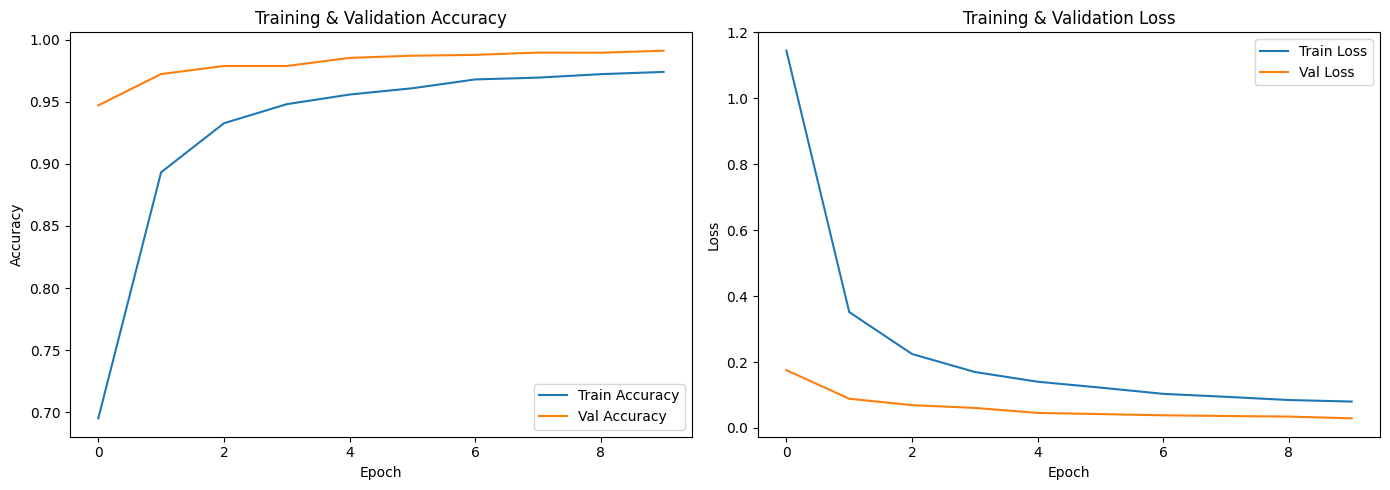

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy/loss
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_ds)

print(f" Test Accuracy: {test_accuracy * 100:.2f}%")
print(f" Test Loss: {test_loss * 100:.2f}%")

679/679 ━━━━━━━━━━━━━━━━━━━━ 214s 315ms/step - accuracy: 0.9899 - loss: 0.0331
 Test Accuracy: 99.06%
 Test Loss: 2.89%


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

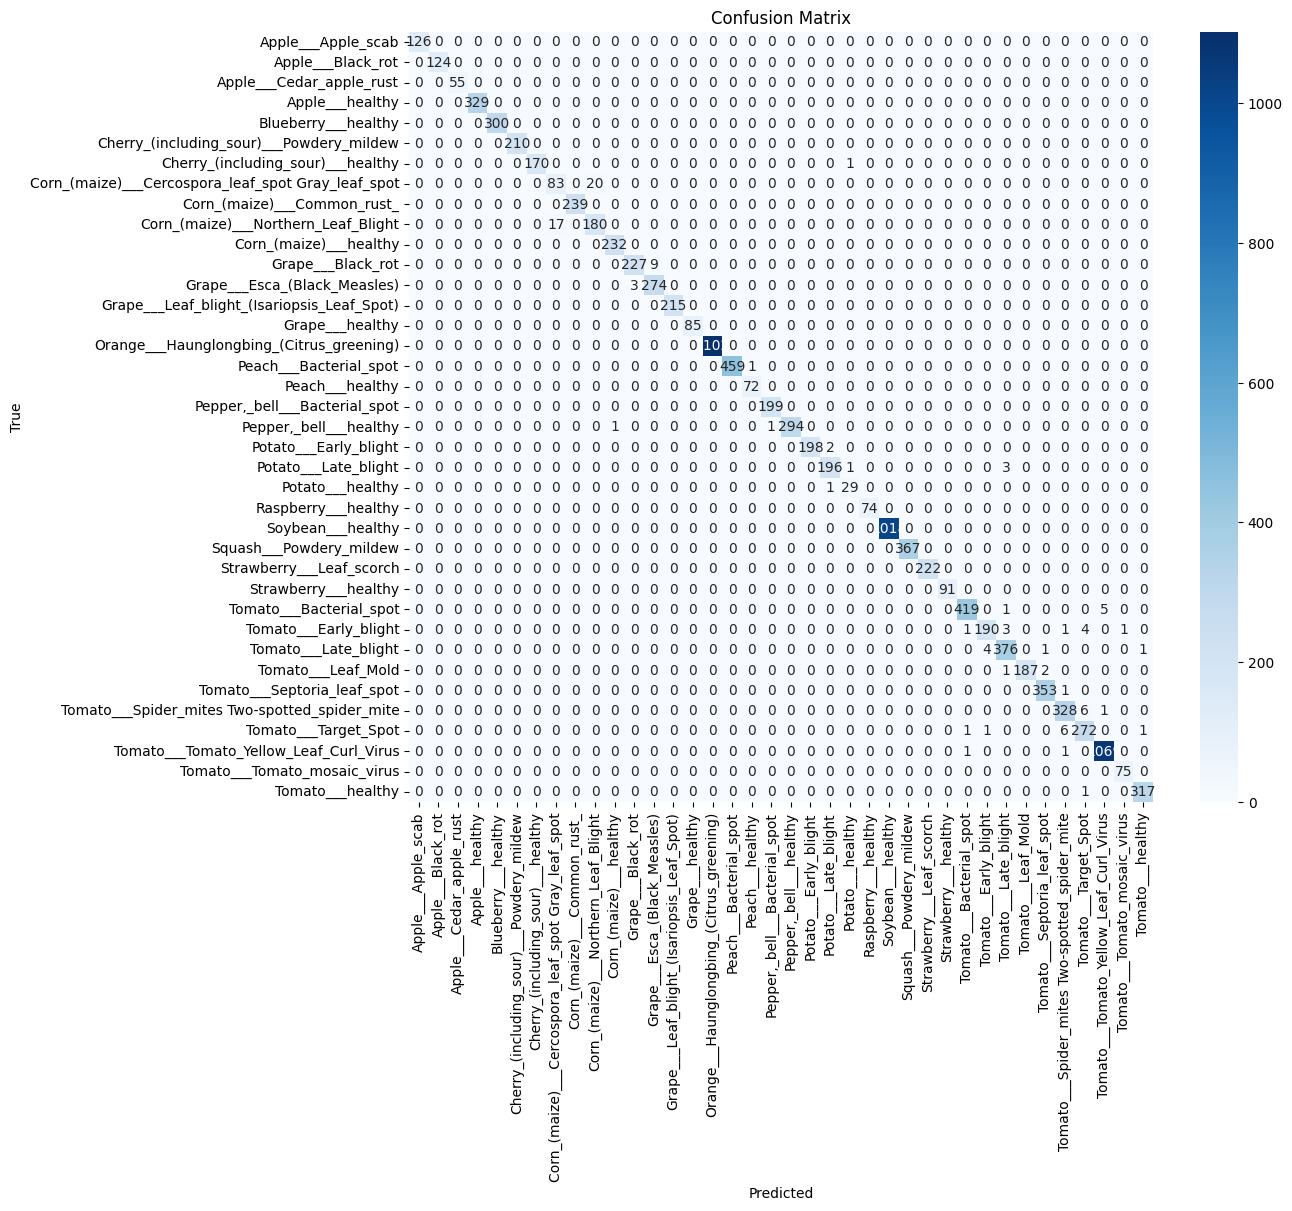

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get predictions and true labels
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Classification Report
report = classification_report(y_true, y_pred, target_names=class_names)
print(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       126
                                 Apple___Black_rot       1.00      1.00      1.00       124
                          Apple___Cedar_apple_rust       1.00      1.00      1.00        55
                                   Apple___healthy       1.00      1.00      1.00       329
                               Blueberry___healthy       1.00      1.00      1.00       300
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.83      0.81      0.82       103
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       239
               Corn_(maize)___Northern_Leaf_Blight       0.90      0.91      0.

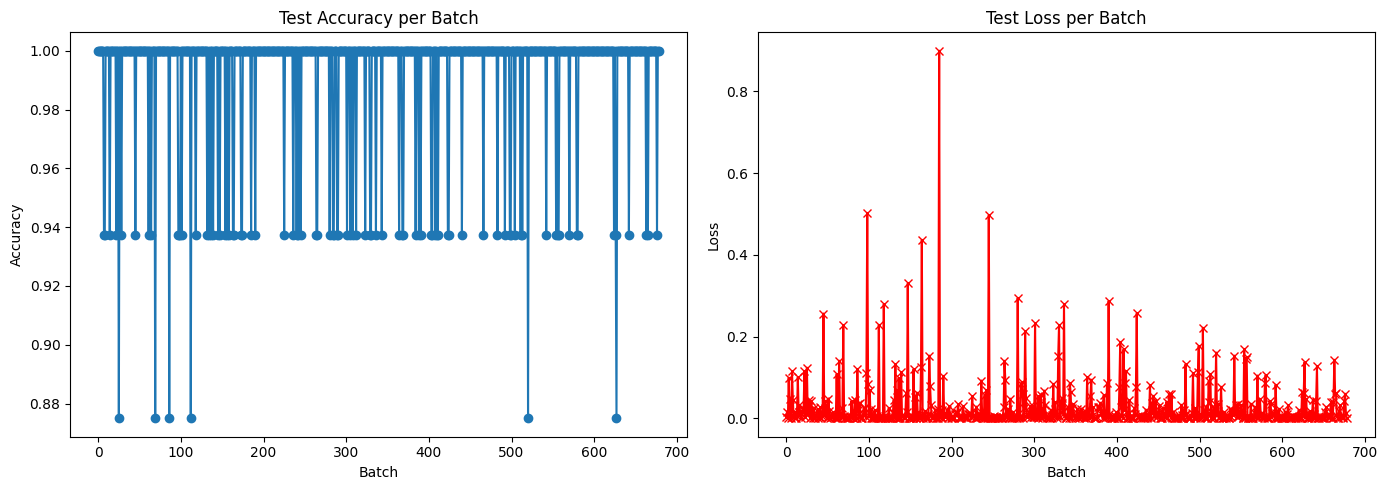

In [ ]:
# Test Accuracy & Loss Plots: Manually track test performance across batches
batch_accuracies = []
batch_losses = []

for images, labels in test_ds:
    loss, acc = model.evaluate(images, labels, verbose=0)
    batch_losses.append(loss)
    batch_accuracies.append(acc)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(batch_accuracies, marker='o')
plt.title('Test Accuracy per Batch')
plt.xlabel('Batch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(batch_losses, marker='x', color='r')
plt.title('Test Loss per Batch')
plt.xlabel('Batch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_4']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Processing Image 1: Label = Soybean___healthy
Processing Image 2: Label = Cherry_(including_sour)___healthy
Processing Image 3: Label = Tomato___Tomato_Yellow_Leaf_Curl_Virus
Processing Image 4: Label = Cherry_(including_sour)___healthy
Processing Image 5: Label = Peach___healthy

🖼️ Image 1
✅ Ground Truth: Soybean___healthy
🔮 Prediction: Soybean___healthy (100.00%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Highlighted red/yellow regions indicate spatial focus areas of the CNN.
- Brighter regions = higher contribution to final classification.
- This helps interpret what part of the input influenced the CNN-ViT output.


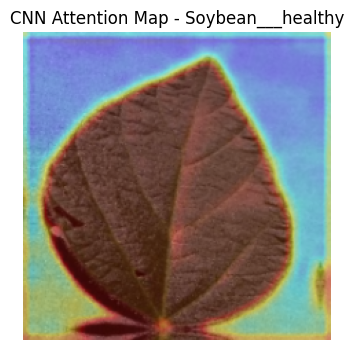


🖼️ Image 2
✅ Ground Truth: Cherry_(including_sour)___healthy
🔮 Prediction: Cherry_(including_sour)___healthy (99.99%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Highlighted red/yellow regions indicate spatial focus areas of the CNN.
- Brighter regions = higher contribution to final classification.
- This helps interpret what part of the input influenced the CNN-ViT output.


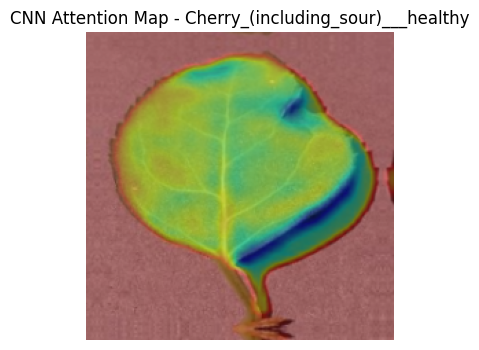


🖼️ Image 3
✅ Ground Truth: Tomato___Tomato_Yellow_Leaf_Curl_Virus
🔮 Prediction: Tomato___Tomato_Yellow_Leaf_Curl_Virus (100.00%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Highlighted red/yellow regions indicate spatial focus areas of the CNN.
- Brighter regions = higher contribution to final classification.
- This helps interpret what part of the input influenced the CNN-ViT output.


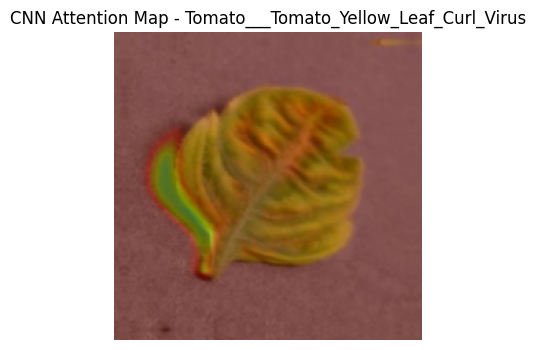


🖼️ Image 4
✅ Ground Truth: Cherry_(including_sour)___healthy
🔮 Prediction: Cherry_(including_sour)___healthy (100.00%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Highlighted red/yellow regions indicate spatial focus areas of the CNN.
- Brighter regions = higher contribution to final classification.
- This helps interpret what part of the input influenced the CNN-ViT output.


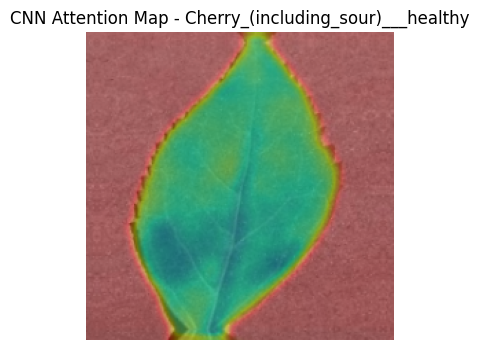


🖼️ Image 5
✅ Ground Truth: Peach___healthy
🔮 Prediction: Peach___healthy (99.94%)
🟢 Model prediction is correct.
🎯 Grad-CAM Explanation:
- Highlighted red/yellow regions indicate spatial focus areas of the CNN.
- Brighter regions = higher contribution to final classification.
- This helps interpret what part of the input influenced the CNN-ViT output.


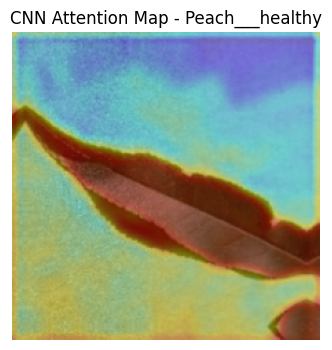

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random

# --- Grad-CAM Helper Functions ---

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy(), predictions.numpy()

def display_and_save_gradcam(img, heatmap, file_name, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(np.uint8(img), 1 - alpha, heatmap_colored, alpha, 0)
    save_path = os.path.join("vitcnn_gradcam_outputs", file_name)
    cv2.imwrite(save_path, cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))
    return save_path

def explain_gradcam_results(selected_images, selected_labels, predictions, gradcam_paths, class_names):
    index_to_class = dict(enumerate(class_names))
    for idx in range(len(selected_images)):
        image = selected_images[idx].numpy()
        label = selected_labels[idx]
        pred = predictions[idx]
        true_class = index_to_class[label]
        pred_class = index_to_class[np.argmax(pred)]
        confidence = np.max(pred) * 100

        print(f"\n🖼️ Image {idx+1}")
        print(f"✅ Ground Truth: {true_class}")
        print(f"🔮 Prediction: {pred_class} ({confidence:.2f}%)")

        if true_class == pred_class:
            print("🟢 Model prediction is correct.")
        else:
            print("🔴 Model prediction is incorrect.")

        print("🎯 Grad-CAM Explanation:")
        print("- Highlighted red/yellow regions indicate spatial focus areas of the CNN.")
        print("- Brighter regions = higher contribution to final classification.")
        print("- This helps interpret what part of the input influenced the CNN-ViT output.")

        plt.figure(figsize=(4, 4))
        cam_img = plt.imread(gradcam_paths[idx])
        plt.imshow(cam_img)
        plt.axis('off')
        plt.title(f"CNN Attention Map - {pred_class}")
        plt.show()

# --- Setup output folder ---
os.makedirs("vitcnn_gradcam_outputs", exist_ok=True)

# --- Target labels (ordered) ---
target_images_info = [
    "Soybean___healthy",
    "Cherry_(including_sour)___healthy",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Cherry_(including_sour)___healthy",
    "Peach___healthy"
]

# --- Map class names to indices ---
label_to_index = {name: idx for idx, name in enumerate(class_names)}
target_indices = [label_to_index[label] for label in target_images_info]

# --- Finding 1 image for each of the 5 target classes ---
found_images = []
found_labels = []
found_count = {idx: 0 for idx in target_indices}

for img, lbl in test_ds.unbatch():
    lbl_val = lbl.numpy()
    if lbl_val in target_indices:
        required = target_images_info.count(class_names[lbl_val])
        if found_count[lbl_val] < required:
            found_images.append(img)
            found_labels.append(lbl_val)
            found_count[lbl_val] += 1
            if len(found_images) == len(target_images_info):
                break

# --- Run Grad-CAM ---
gradcam_paths = []
all_predictions = []

for idx, (img, label) in enumerate(zip(found_images, found_labels)):
    input_array = np.expand_dims(img.numpy(), axis=0)
    heatmap, prediction = make_gradcam_heatmap(input_array, model, last_conv_layer_name="conv2d_2")  # CNN layer
    file_name = f"vitcnn_gradcam_{idx+1}_{class_names[label]}.png"
    print(f"Processing Image {idx+1}: Label = {class_names[label]}")
    full_path = display_and_save_gradcam(np.uint8(img.numpy() * 255), heatmap, file_name)
    gradcam_paths.append(full_path)
    all_predictions.append(prediction[0])

# --- Show Explanation ---
explain_gradcam_results(found_images, found_labels, all_predictions, gradcam_paths, class_names)
